# Pregunta 6

(2 puntos) La imagen Ex3Preg6(a).tif muestra una imagen tomada con un microscopio de cultivo de bacterias identificadas por los círculos intensos:

a. (0.5 puntos) Usando una técnica de umbralización global, segmente la imagen y muestre el resultado de la segmetnación.

b. (0.5 puntos) A la imagenoriginal se le aplicó una umbralización con valores locales yal resultado se le realizó una apertura morbológica obteniendo la imagen Ex3Preg6(b).tif. Usando esta imagen,cuente y etiquete cuantos objetos de la segmentación pueden considerarse células independientes. 

c. (1 punto) Continuando con la imagen anterior. Cuente y etiquete cuantos objetos de la segmentación pueden considerarse 2 células agrupadas, y cuantos y cuales más de 2 células.

In [6]:
from functools import partial, reduce

import matplotlib.pyplot as plt
import matplotlib.image as img

import numpy as np
import cv2 

from mfilt_funcs import *
from utils import *

In [11]:
# Read image as gray-scale
img  = cv2.imread('imagenes/Ex3Preg6(a).tif', cv2.IMREAD_GRAYSCALE)
img2 = img.copy()
# Blur the image to reduce noise
img_blur = cv2.medianBlur(img, 5)
# Apply hough transform on the image
circles = cv2.HoughCircles(img_blur, cv2.HOUGH_GRADIENT, 1, img.shape[0]/64, param1=200, param2=10, minRadius=5, maxRadius=7)
# Draw detected circles
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        # Draw outer circle
        cv2.circle(img, (i[0], i[1]), i[2], (0, 255, 0), 2)
        # Draw inner circle
        #cv2.circle(img, (i[0], i[1]), 2, (0, 0, 255), 3)

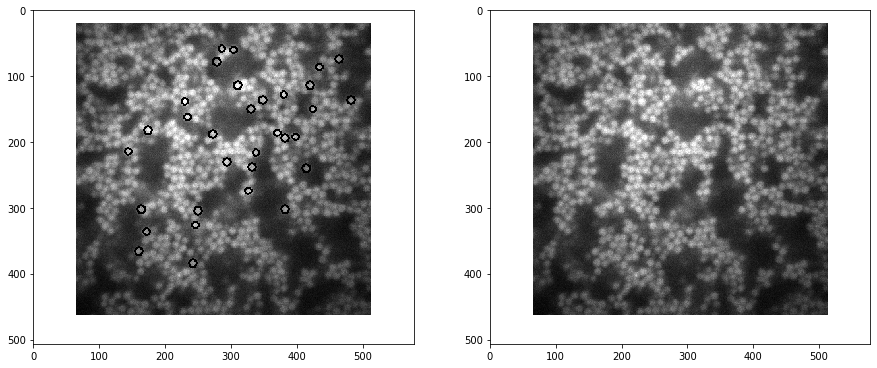

In [12]:
side_by_side(img, img2)

In [10]:
help(cv2.HoughCircles)

Help on built-in function HoughCircles:

HoughCircles(...)
    HoughCircles(image, method, dp, minDist[, circles[, param1[, param2[, minRadius[, maxRadius]]]]]) -> circles
    .   @brief Finds circles in a grayscale image using the Hough transform.
    .   
    .   The function finds circles in a grayscale image using a modification of the Hough transform.
    .   
    .   Example: :
    .   @include snippets/imgproc_HoughLinesCircles.cpp
    .   
    .   @note Usually the function detects the centers of circles well. However, it may fail to find correct
    .   radii. You can assist to the function by specifying the radius range ( minRadius and maxRadius ) if
    .   you know it. Or, you may set maxRadius to a negative number to return centers only without radius
    .   search, and find the correct radius using an additional procedure.
    .   
    .   @param image 8-bit, single-channel, grayscale input image.
    .   @param circles Output vector of found circles. Each vector is enco